Hopefully this notebook is now a working example of the multinomial player model.

In [1]:
import os

import pandas as pd

import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist

from numpyro.infer import MCMC, NUTS, Predictive

import matplotlib.pyplot as plt


Get a sample of player data.  Just look at forwards, with data up to the middle of the 2019/20 season.

In [2]:
from airsenal.framework.prediction_utils import process_player_data
from airsenal.framework.utils import get_player, NEXT_GAMEWEEK
from airsenal.framework.season import CURRENT_SEASON

In [3]:
def get_player_data(position, season="1920", latest_gameweek=38):
    data = process_player_data(position, season, latest_gameweek)
    return data

In [4]:
data = get_player_data("FWD")

Filling history dataframe for Sergio Agüero: 0/87 done
Filling history dataframe for Pierre-Emerick Aubameyang: 1/87 done
Filling history dataframe for Harry Kane: 2/87 done
Filling history dataframe for Jamie Vardy: 3/87 done
Filling history dataframe for Gabriel Fernando de Jesus: 4/87 done
Filling history dataframe for Roberto Firmino: 5/87 done
Filling history dataframe for Alexandre Lacazette: 6/87 done
Filling history dataframe for Marcus Rashford: 7/87 done
Filling history dataframe for Romelu Lukaku: 8/87 done
Filling history dataframe for Raúl Jiménez: 9/87 done
Filling history dataframe for Tammy Abraham: 10/87 done
Filling history dataframe for Callum Wilson: 11/87 done
Filling history dataframe for Danny Ings: 12/87 done
Filling history dataframe for Marko Arnautovic: 13/87 done
Filling history dataframe for Sébastien Haller: 14/87 done
Filling history dataframe for Olivier Giroud: 15/87 done
Filling history dataframe for Michy Batshuayi: 16/87 done
Filling history datafram

this gives us a dict with keys:
```
"player_ids" (list of ints),
"nplayer" (int), 
"nmatch" (int), 
"minutes" (numpy array with shape (nplayer, nmatch)), 
"y" (numpy array with shape (nplayer, nmatch, 3)), 
"alpha" (numpy array with shape (3,))
```


### numpyro model

The below took a lot of iterations to figure out how to broadcast over the right dimensions.
Hopefully it's sort-of right...


In [5]:
def model(nplayer, nmatch, minutes, y, alpha):
    theta = dist.Dirichlet(concentration=alpha)
    # one sample from the prior per player
    with numpyro.plate("nplayer", nplayer) as player_index:
        dprobs = numpyro.sample("probs", theta) 
    # now it's all about how to broadcast in the right dimensions.....
    prob_score = numpyro.deterministic("prob_score",dprobs[:,0,None] * (minutes / 90.))
    prob_assist = numpyro.deterministic("prob_assist",dprobs[:,1,None] * (minutes / 90.))
    prob_neither = numpyro.deterministic("prob_neither",dprobs[:,2,None] * (minutes / 90.) + (90. - minutes))
    theta_mins = dist.Multinomial(
                probs=jnp.moveaxis(jnp.array([prob_score, prob_assist, prob_neither]),0,2)
    )
    return numpyro.sample("obs", theta_mins, obs=y)

In [6]:
def fit_model(data, model):
    kernel = NUTS(model)
    mcmc = MCMC(
    kernel,
    num_warmup=1500,
    num_samples=3000,
    num_chains=1,
    progress_bar=True
    )
    rng_key, rng_key_predict = random.split(random.PRNGKey(44))
    mcmc.run(rng_key,
         data["nplayer"],
         data["nmatch"],
         data["minutes"],
         data["y"],
         data["alpha"]
    )
    return mcmc.get_samples()

In [7]:
def get_probs(player_index, samples):
    prob_score = float(samples["probs"][:,player_index,0].mean())
    prob_assist = float(samples["probs"][:,player_index,1].mean())
    prob_neither = float(samples["probs"][:,player_index,2].mean())
    return (prob_score, prob_assist, prob_neither)

In [8]:
def create_dataframe(names, samples):
    prob_dict = {"name":[],"prob_score": [], "prob_assist": [], "prob_neither": []}
    for i, pid in enumerate(names):
        pid = int(pid)
        prob_dict["name"].append(get_player(pid).name)
        probs = get_probs(i, samples)
        prob_dict["prob_score"].append(probs[0])
        prob_dict["prob_assist"].append(probs[1])
        prob_dict["prob_neither"].append(probs[2])
    df = pd.DataFrame(prob_dict)
    return df

In [9]:
def run_model(position="FWD",season="1920",latest_gameweek=38):
    data = get_player_data(position, season, latest_gameweek)
    samples = fit_model(data, model)
    df = create_dataframe(data["player_ids"], samples)
    return df

Now go through the whole chain for each position in turn

In [10]:
df_fwd = run_model("FWD", season=CURRENT_SEASON, latest_gameweek=NEXT_GAMEWEEK)
df_mid = run_model("MID", season=CURRENT_SEASON, latest_gameweek=NEXT_GAMEWEEK)
df_def = run_model("DEF", season=CURRENT_SEASON, latest_gameweek=NEXT_GAMEWEEK)

Filling history dataframe for Harry Kane: 0/75 done
Filling history dataframe for Romelu Lukaku: 1/75 done
Filling history dataframe for Jamie Vardy: 2/75 done
Filling history dataframe for Pierre-Emerick Aubameyang: 3/75 done
Filling history dataframe for Timo Werner: 4/75 done
Filling history dataframe for Roberto Firmino: 5/75 done
Filling history dataframe for Alexandre Lacazette: 6/75 done
Filling history dataframe for Gabriel Fernando de Jesus: 7/75 done
Filling history dataframe for Edinson Cavani: 8/75 done
Filling history dataframe for Danny Ings: 9/75 done
Filling history dataframe for Dominic Calvert-Lewin: 10/75 done
Filling history dataframe for Patrick Bamford: 11/75 done
Filling history dataframe for Anthony Martial: 12/75 done
Filling history dataframe for Richarlison de Andrade: 13/75 done
Filling history dataframe for Ollie Watkins: 14/75 done
Filling history dataframe for Kelechi Iheanacho: 15/75 done
Filling history dataframe for Patson Daka: 16/75 done
Filling hist

sample: 100%|████████| 4500/4500 [00:13<00:00, 342.12it/s, 7 steps of size 4.62e-01. acc. prob=0.80]


Filling history dataframe for Mohamed Salah: 0/233 done
Filling history dataframe for Bruno Miguel Borges Fernandes: 1/233 done
Filling history dataframe for Sadio Mané: 2/233 done
Filling history dataframe for Kevin De Bruyne: 3/233 done
Filling history dataframe for Raheem Sterling: 4/233 done
Filling history dataframe for Heung-Min Son: 5/233 done
Filling history dataframe for Marcus Rashford: 6/233 done
Filling history dataframe for Jadon Sancho: 7/233 done
Filling history dataframe for Riyad Mahrez: 8/233 done
Filling history dataframe for Kai Havertz: 9/233 done
Filling history dataframe for Christian Pulisic: 10/233 done
Filling history dataframe for Jack Grealish: 11/233 done
Filling history dataframe for Phil Foden: 12/233 done
Filling history dataframe for Paul Pogba: 13/233 done
Filling history dataframe for Nicolas Pépé: 14/233 done
Filling history dataframe for Hakim Ziyech: 15/233 done
Filling history dataframe for Mason Mount: 16/233 done
Filling history dataframe for Di

Filling history dataframe for Mateo Kovacic: 137/233 done
Filling history dataframe for N'Golo Kanté: 138/233 done
Filling history dataframe for Jairo Riedewald: 139/233 done
Filling history dataframe for André Filipe Tavares Gomes: 140/233 done
Filling history dataframe for Tom Davies: 141/233 done
Filling history dataframe for Dennis Praet: 142/233 done
Filling history dataframe for Wilfred Ndidi: 143/233 done
Filling history dataframe for Boubakary Soumaré: 144/233 done
Filling history dataframe for Kalvin Phillips: 145/233 done
Filling history dataframe for Tyler Roberts: 146/233 done
Filling history dataframe for James Milner: 147/233 done
Filling history dataframe for Jordan Henderson: 148/233 done
Filling history dataframe for Naby Keita: 149/233 done
Filling history dataframe for Curtis Jones: 150/233 done
Filling history dataframe for Fernando Luiz Rosa: 151/233 done
Filling history dataframe for Samuel Edozie: 152/233 done
Filling history dataframe for Frederico Rodrigues de 

sample: 100%|███████| 4500/4500 [00:41<00:00, 109.69it/s, 15 steps of size 3.00e-01. acc. prob=0.86]


Filling history dataframe for Trent Alexander-Arnold: 0/189 done
Filling history dataframe for Andrew Robertson: 1/189 done
Filling history dataframe for Virgil van Dijk: 2/189 done
Filling history dataframe for César Azpilicueta: 3/189 done
Filling history dataframe for Benjamin Chilwell: 4/189 done
Filling history dataframe for João Pedro Cavaco Cancelo: 5/189 done
Filling history dataframe for Rúben Santos Gato Alves Dias: 6/189 done
Filling history dataframe for Thiago Emiliano da Silva: 7/189 done
Filling history dataframe for Marcos Alonso: 8/189 done
Filling history dataframe for Antonio Rüdiger: 9/189 done
Filling history dataframe for Kurt Zouma: 10/189 done
Filling history dataframe for Reece James: 11/189 done
Filling history dataframe for Lucas Digne: 12/189 done
Filling history dataframe for Jonny Evans: 13/189 done
Filling history dataframe for Ricardo Domingos Barbosa Pereira: 14/189 done
Filling history dataframe for Timothy Castagne: 15/189 done
Filling history datafra

Filling history dataframe for Brandon Williams: 175/189 done
Filling history dataframe for Javier Manquillo: 176/189 done
Filling history dataframe for Andrew Omobamidele: 177/189 done
Filling history dataframe for Bali Mumba: 178/189 done
Filling history dataframe for Tino Livramento: 179/189 done
Filling history dataframe for Yan Valery: 180/189 done
Filling history dataframe for Marc Navarro: 181/189 done
Filling history dataframe for Matthew Pollock: 182/189 done
Filling history dataframe for Winston Reid: 183/189 done
Filling history dataframe for Ben Johnson: 184/189 done
Filling history dataframe for Frederik Alves: 185/189 done
Filling history dataframe for Jamal Baptiste: 186/189 done
Filling history dataframe for Ki-Jana Hoever: 187/189 done
Filling history dataframe for Christian Marques: 188/189 done
Alpha is [ 2.20695308  3.80735945 66.82079385]


sample: 100%|███████| 4500/4500 [00:38<00:00, 117.98it/s, 15 steps of size 2.65e-01. acc. prob=0.88]


Text(0, 0.5, 'P(assist)')

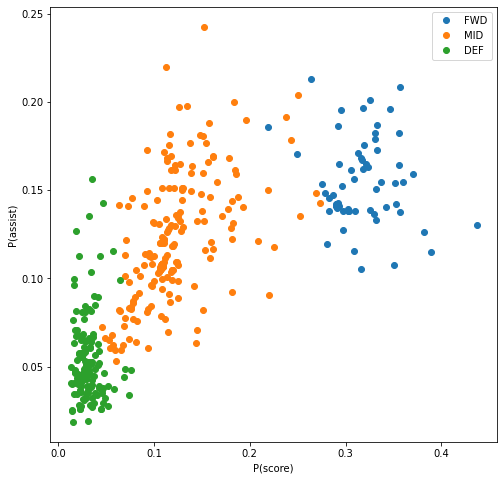

In [11]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(8,8))
plt.plot(df_fwd['prob_score'], df_fwd['prob_assist'], 'o', label='FWD')
plt.plot(df_mid['prob_score'], df_mid['prob_assist'], 'o', label='MID')
plt.plot(df_def['prob_score'], df_def['prob_assist'], 'o', label='DEF')
plt.legend()
plt.xlabel('P(score)')
plt.ylabel('P(assist)')


In [12]:
df_fwd.sort_values(by='prob_score', ascending=False).head(10)

,name,prob_score,prob_assist,prob_neither
7,Danny Ings,0.436643,0.130513,0.432844
17,Chris Wood,0.388925,0.114703,0.496372
0,Pierre-Emerick Aubameyang,0.381972,0.126044,0.491984
19,Olivier Giroud,0.369933,0.159366,0.470701
22,Tammy Abraham,0.359916,0.154560,0.485524
26,Dominic Calvert-Lewin,0.357257,0.137516,0.505227
37,Anthony Martial,0.356406,0.208686,0.434908
28,Jamie Vardy,0.355651,0.164212,0.480137
64,Raúl Jiménez,0.355503,0.182633,0.461864
51,Harry Kane,0.352839,0.142425,0.504735


In [13]:
df_mid.sort_values(by='prob_score', ascending=False).head(10)

,name,prob_score,prob_assist,prob_neither
115,Mohamed Salah,0.273805,0.142624,0.583571
118,Diogo Jota,0.268702,0.148473,0.582825
113,Sadio Mané,0.252196,0.135145,0.612660
178,Heung-Min Son,0.250461,0.204082,0.545457
138,Marcus Rashford,0.243572,0.178158,0.578270
137,Bruno Miguel Borges Fernandes,0.238181,0.191716,0.570103
91,Ayoze Pérez,0.225603,0.117771,0.656626
142,Mason Greenwood,0.220313,0.090482,0.689204
125,Raheem Sterling,0.218636,0.150042,0.631322
19,Anwar El Ghazi,0.208516,0.121247,0.670237


In [14]:
data_fwd = get_player_data("FWD", CURRENT_SEASON, NEXT_GAMEWEEK)

Filling history dataframe for Harry Kane: 0/75 done
Filling history dataframe for Romelu Lukaku: 1/75 done
Filling history dataframe for Jamie Vardy: 2/75 done
Filling history dataframe for Pierre-Emerick Aubameyang: 3/75 done
Filling history dataframe for Timo Werner: 4/75 done
Filling history dataframe for Roberto Firmino: 5/75 done
Filling history dataframe for Alexandre Lacazette: 6/75 done
Filling history dataframe for Gabriel Fernando de Jesus: 7/75 done
Filling history dataframe for Edinson Cavani: 8/75 done
Filling history dataframe for Danny Ings: 9/75 done
Filling history dataframe for Dominic Calvert-Lewin: 10/75 done
Filling history dataframe for Patrick Bamford: 11/75 done
Filling history dataframe for Anthony Martial: 12/75 done
Filling history dataframe for Richarlison de Andrade: 13/75 done
Filling history dataframe for Ollie Watkins: 14/75 done
Filling history dataframe for Kelechi Iheanacho: 15/75 done
Filling history dataframe for Patson Daka: 16/75 done
Filling hist

In [15]:
from scipy.stats import dirichlet

prior = dirichlet(data_fwd["alpha"])
sample = prior.rvs(1000)

Text(0.5, 1.0, 'p_neither')

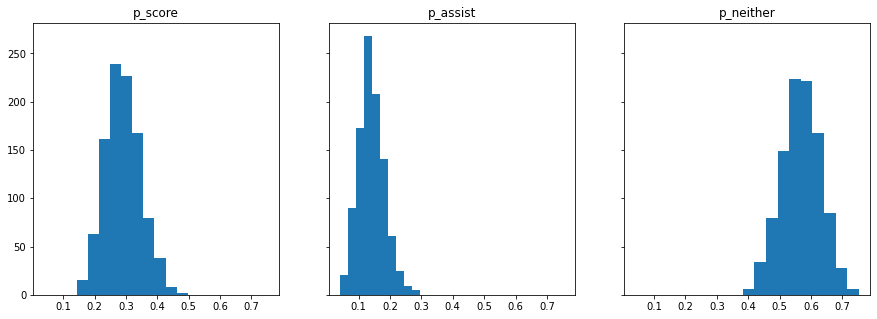

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax[0].hist(sample[:, 0])
ax[0].set_title("p_score")
ax[1].hist(sample[:, 1])
ax[1].set_title("p_assist")
ax[2].hist(sample[:, 2])
ax[2].set_title("p_neither")

In [17]:
from airsenal.framework.prediction_utils import get_empirical_bayes_estimates, get_player_history_df

df = get_player_history_df(
    "FWD", season=CURRENT_SEASON, gameweek=NEXT_GAMEWEEK
)
df["neither"] = df["team_goals"] - df["goals"] - df["assists"]
df.loc[(df["neither"] < 0), ["neither", "team_goals", "goals", "assists"]] = [
    0.0,
    0.0,
    0.0,
    0.0,
]

emp_fwd = {}
for idx, data in df.groupby("player_id"):
    print(data["player_name"].iloc[0])
    alpha = get_empirical_bayes_estimates(data)
    emp_fwd[idx] = alpha / alpha.sum()

emp_fwd = pd.DataFrame(emp_fwd).T
emp_fwd.columns = ["emp_score", "emp_assist", "emp_neither"]
emp_fwd["name"] = [get_player(idx).name for idx in emp_fwd.index]
emp_fwd

Filling history dataframe for Harry Kane: 0/75 done
Filling history dataframe for Romelu Lukaku: 1/75 done
Filling history dataframe for Jamie Vardy: 2/75 done
Filling history dataframe for Pierre-Emerick Aubameyang: 3/75 done
Filling history dataframe for Timo Werner: 4/75 done
Filling history dataframe for Roberto Firmino: 5/75 done
Filling history dataframe for Alexandre Lacazette: 6/75 done
Filling history dataframe for Gabriel Fernando de Jesus: 7/75 done
Filling history dataframe for Edinson Cavani: 8/75 done
Filling history dataframe for Danny Ings: 9/75 done
Filling history dataframe for Dominic Calvert-Lewin: 10/75 done
Filling history dataframe for Patrick Bamford: 11/75 done
Filling history dataframe for Anthony Martial: 12/75 done
Filling history dataframe for Richarlison de Andrade: 13/75 done
Filling history dataframe for Ollie Watkins: 14/75 done
Filling history dataframe for Kelechi Iheanacho: 15/75 done
Filling history dataframe for Patson Daka: 16/75 done
Filling hist

/Users/jroberts/GitHub/AIrsenal/airsenal/framework/prediction_utils.py:478: RuntimeWarning: divide by zero encountered in long_scalars
  a0 = neff * (goals / team) * (total_minutes / minutes)
/Users/jroberts/GitHub/AIrsenal/airsenal/framework/prediction_utils.py:478: RuntimeWarning: invalid value encountered in double_scalars
  a0 = neff * (goals / team) * (total_minutes / minutes)
/Users/jroberts/GitHub/AIrsenal/airsenal/framework/prediction_utils.py:479: RuntimeWarning: divide by zero encountered in long_scalars
  a1 = neff * (assists / team) * (total_minutes / minutes)
/Users/jroberts/GitHub/AIrsenal/airsenal/framework/prediction_utils.py:479: RuntimeWarning: invalid value encountered in double_scalars
  a1 = neff * (assists / team) * (total_minutes / minutes)
/Users/jroberts/GitHub/AIrsenal/airsenal/framework/prediction_utils.py:483: RuntimeWarning: divide by zero encountered in long_scalars
  * (total_minutes / minutes)
/Users/jroberts/GitHub/AIrsenal/airsenal/framework/prediction


Tammy Abraham
Alpha is [40.00897972 15.24151608 59.74950419]
Christian Benteke
Alpha is [32.25609756  9.9249531  72.81894934]
Jordan Ayew
Alpha is [16.37617261 14.88742964 83.73639775]
Jean-Philippe Mateta
Alpha is [ 6.99164886  0.         13.00835114]
Dominic Calvert-Lewin
Alpha is [39.38515444 13.12838481 62.48646075]
Richarlison de Andrade
Alpha is [31.49456471 13.8946609  69.61077439]
Jamie Vardy
Alpha is [41.76876306 19.05241824 54.1788187 ]
Kelechi Iheanacho
Alpha is [34.23051052 20.91864532 59.85084416]
Patson Daka
Alpha is [nan nan nan]
Rodrigo Moreno
Alpha is [11.48791541  6.56452309 20.9475615 ]
Patrick Bamford
Alpha is [11.80900621  7.64112167 19.54987212]
Roberto Firmino
Alpha is [17.80809521 14.36136711 82.83053768]
Divock Origi
Alpha is [25.22952884 14.41687362 67.35359754]
Gabriel Fernando de Jesus
Alpha is [24.95143528 13.30743215 76.74113257]
Edinson Cavani
Alpha is [11.7141365   4.6856546  19.60020889]
Anthony Martial
Alpha is [30.8105163  19.87775245 64.31173126]
Ca

,emp_score,emp_assist,emp_neither,name
4,0.370970,0.103047,0.525983,Pierre-Emerick Aubameyang
6,0.322452,0.197054,0.480494,Alexandre Lacazette
20,0.267096,0.053419,0.679485,Edward Nketiah
42,0.259046,0.166530,0.574424,Ollie Watkins
49,0.196756,0.039351,0.763892,Wesley Moraes
...,...,...,...,...
669,NaN,NaN,NaN,Sam Greenwood
926,0.291908,0.024326,0.683766,Romelu Lukaku
1184,NaN,NaN,NaN,Folarin Balogun
1188,1.000000,0.000000,0.000000,Adam Armstrong


In [18]:
emp_fwd

,emp_score,emp_assist,emp_neither,name
4,0.370970,0.103047,0.525983,Pierre-Emerick Aubameyang
6,0.322452,0.197054,0.480494,Alexandre Lacazette
20,0.267096,0.053419,0.679485,Edward Nketiah
42,0.259046,0.166530,0.574424,Ollie Watkins
49,0.196756,0.039351,0.763892,Wesley Moraes
...,...,...,...,...
669,NaN,NaN,NaN,Sam Greenwood
926,0.291908,0.024326,0.683766,Romelu Lukaku
1184,NaN,NaN,NaN,Folarin Balogun
1188,1.000000,0.000000,0.000000,Adam Armstrong


In [19]:
df_fit = pd.merge(df_fwd, emp_fwd, on="name", how="inner")
df_fit.set_index("name", inplace=True)

In [20]:
(df_fit["prob_score"] - df_fit["emp_score"]).dropna().sort_values()

name
Juan Camilo Hernández Suárez    -0.947735
Adam Armstrong                  -0.696284
Patrick Cutrone                 -0.186656
Emmanuel Dennis                 -0.165573
Teemu Pukki                     -0.159201
                                   ...   
Marcus Forss                     0.291000
Adam Idah                        0.291294
Daniel N'Lundulu                 0.291642
Dane Scarlett                    0.292065
João Pedro Junqueira de Jesus    0.292138
Length: 64, dtype: float64

Text(0.5, 1.0, 'Player Posterior p_neither')

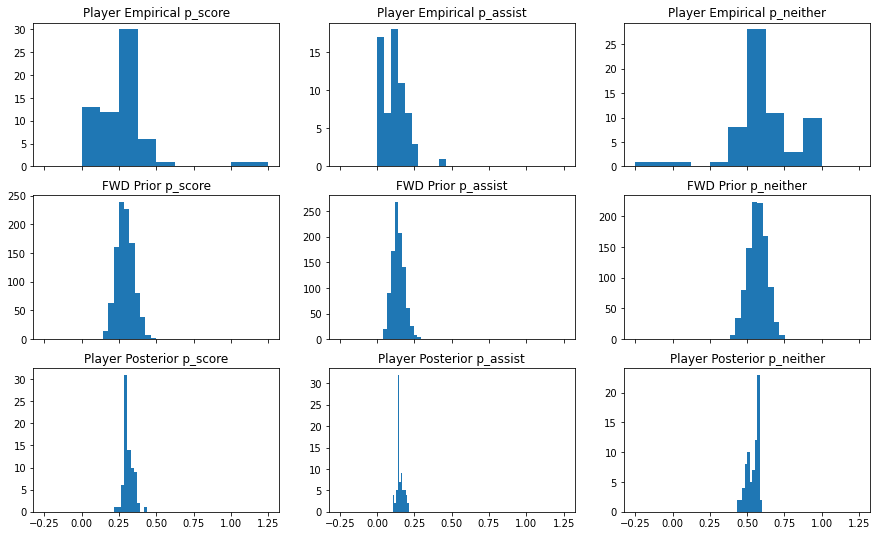

In [21]:
fig, ax = plt.subplots(3, 3, figsize=(15, 9), sharex=True, sharey=False)
ax[0, 0].hist(emp_fwd["emp_score"])
ax[0, 0].set_title("Player Empirical p_score")
ax[0, 1].hist(emp_fwd["emp_assist"])
ax[0, 1].set_title("Player Empirical p_assist")
ax[0, 2].hist(emp_fwd["emp_neither"])
ax[0, 2].set_title("Player Empirical p_neither")

ax[1, 0].hist(sample[:, 0])
ax[1, 0].set_title("FWD Prior p_score")
ax[1, 1].hist(sample[:, 1])
ax[1, 1].set_title("FWD Prior p_assist")
ax[1, 2].hist(sample[:, 2])
ax[1, 2].set_title("FWD Prior p_neither")

ax[2, 0].hist(df_fwd["prob_score"])
ax[2, 0].set_title("Player Posterior p_score")
ax[2, 1].hist(df_fwd["prob_assist"])
ax[2, 1].set_title("Player Posterior p_assist")
ax[2, 2].hist(df_fwd["prob_neither"])
ax[2, 2].set_title("Player Posterior p_neither")

In [22]:
# empirical
emp_fwd["emp_score"].describe()

count    64.000000
mean      0.266503
std       0.207105
min       0.000000
25%       0.151740
50%       0.278787
75%       0.333905
max       1.250000
Name: emp_score, dtype: float64

In [23]:
# prior
print(sample[:, 0].mean(), sample[:, 0].std())

0.29079466599812415 0.056853509320681506


In [24]:
# posterior
df_fwd["prob_score"].describe()

count    75.000000
mean      0.312402
std       0.033285
min       0.219613
25%       0.291147
50%       0.303716
75%       0.331078
max       0.436643
Name: prob_score, dtype: float64

In [25]:
df_fit.loc["Roberto Firmino"]

prob_score      0.249176
prob_assist     0.170757
prob_neither    0.580067
emp_score       0.154853
emp_assist      0.124881
emp_neither     0.720266
Name: Roberto Firmino, dtype: float64

In [26]:
emp_fwd

,emp_score,emp_assist,emp_neither,name
4,0.370970,0.103047,0.525983,Pierre-Emerick Aubameyang
6,0.322452,0.197054,0.480494,Alexandre Lacazette
20,0.267096,0.053419,0.679485,Edward Nketiah
42,0.259046,0.166530,0.574424,Ollie Watkins
49,0.196756,0.039351,0.763892,Wesley Moraes
...,...,...,...,...
669,NaN,NaN,NaN,Sam Greenwood
926,0.291908,0.024326,0.683766,Romelu Lukaku
1184,NaN,NaN,NaN,Folarin Balogun
1188,1.000000,0.000000,0.000000,Adam Armstrong


In [27]:
# exact posterior
import numpy as np
prior = np.array([24.55477665, 12.03720926, 47.90801409])
prior = 13 * prior / prior.sum()
data = np.array([17.20, 14.34, 82.46])
posterior = prior + data
posterior / posterior.sum()

array([0.16517841, 0.12749511, 0.70732649])